In [1]:
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point, LineString, MultiLineString
import json
import osmnx as ox
import contextily as ctx
import zipfile
import pandas as pd
import os
import re
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as colors
import numpy as np
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from spreg.diagnostics_sp import LMtests
from spreg import OLS, ML_Lag, ML_Error
from libpysal.weights import KNN, W
from esda.moran import Moran_Local, Moran
from r5py import TransportNetwork, TravelTimeMatrix, TransportMode
import datetime

In [2]:
if not os.path.exists('quartieri'):
    zip_file_name = "quartieri.zip"
    z = zipfile.ZipFile(zip_file_name)
    z.extractall('quartieri')

if not os.path.exists('gtfs_data'):
    zip_file_name = "gtfs_data.zip"
    z = zipfile.ZipFile(zip_file_name)
    z.extractall('gtfs_data')

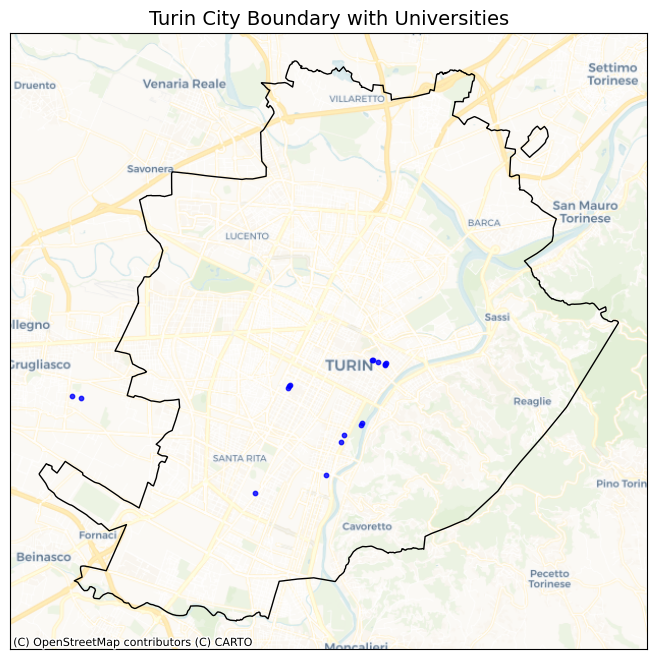

In [4]:
cityname = 'Torino, Italy'
turin = ox.geocode_to_gdf(cityname)
turin = turin.to_crs(epsg=3857)
university=gpd.read_file('facolta/facolta.shp')
university = university.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 8))

turin.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
university.plot(ax=ax, facecolor="blue", markersize=10, alpha=0.8)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, alpha=0.8)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Turin City Boundary with Universities", fontsize=14)
plt.show()

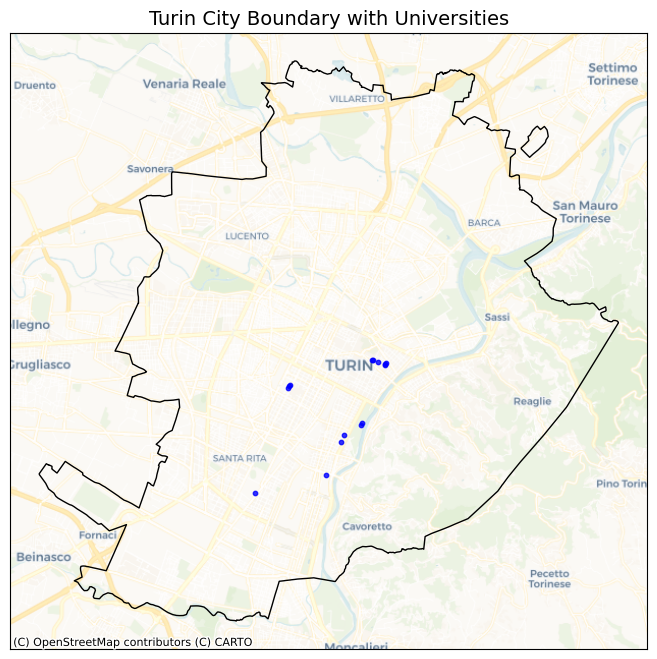

In [ ]:
university_within = gpd.sjoin(university, turin, predicate="within")

fig, ax = plt.subplots(figsize=(10, 8))
turin.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
university_within.plot(ax=ax, facecolor="blue", markersize=10, alpha=0.8)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, alpha=0.8)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Turin City Boundary with Universities", fontsize=14)
plt.show()

c:\Users\re_ma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


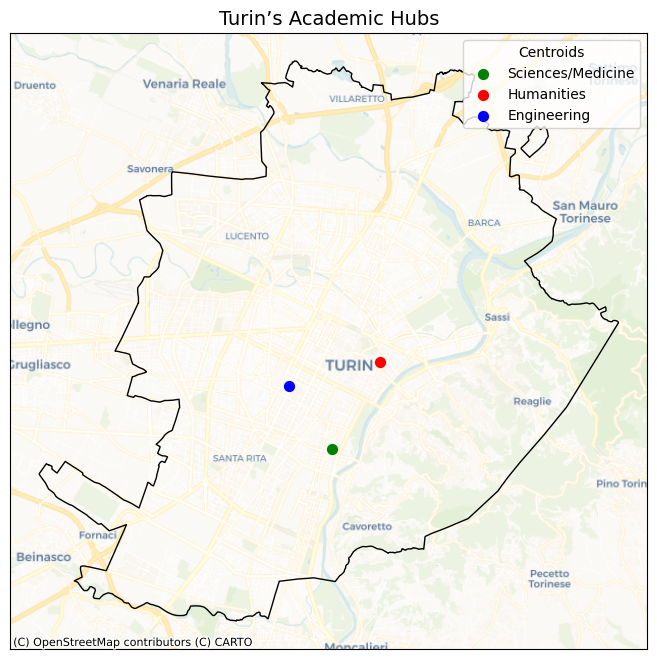

In [ ]:
university_within_proj = university_within.to_crs(epsg=3857)

coords = list(zip(university_within_proj.geometry.x, university_within_proj.geometry.y))
kmeans = KMeans(n_clusters=3, random_state=0)
university_within_proj["cluster"] = kmeans.fit_predict(coords)

university_within["cluster"] = university_within_proj["cluster"]

centroids = university_within.dissolve(by="cluster").centroid
centroids = gpd.GeoDataFrame(geometry=centroids, crs=university_within.crs)
centroids["cluster"] = centroids.index

cluster_labels = {
    0: "Sciences/Medicine",
    1: "Humanities",
    2: "Engineering"
}
cluster_colors = {
    0: "green",
    1: "red",
    2: "blue"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
turin.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

for cluster_id, label in cluster_labels.items():
    subset = centroids[centroids["cluster"] == cluster_id]
    subset.plot(ax=ax, color=cluster_colors[cluster_id], markersize=50, label=label)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, alpha=0.8)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Turin’s Academic Hubs", fontsize=14)
ax.legend(title="Centroids")
plt.show()

THERE IS A MISMATCH IN LE VALETTE 

C:\Users\re_ma\AppData\Local\Temp\ipykernel_20644\878225199.py:44: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


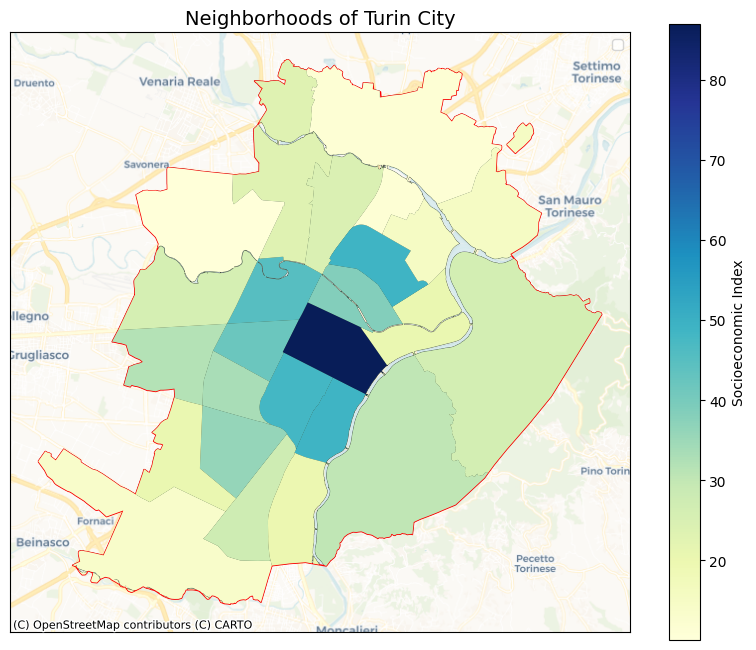

In [ ]:
neighborhoods = gpd.read_file('quartieri/ex_neighborhood_boundary.shp')

neighborhoods = neighborhoods.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))
neighborhoods.plot(ax=ax, facecolor="lightgreen", edgecolor="black", alpha=0.7, linewidth=0.5, label="Neighborhoods")
turin.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, label="Turin City Boundary")


socioeconomic_data = pd.read_csv('quartieri/data.csv', sep=';')
socioeconomic_data.columns = ['Quartiere', 'Ind. socioeconomico', 'Var.']

socioeconomic_data['Quartiere'] = socioeconomic_data['Quartiere'].str.upper()
neighborhoods['DENOM'] = neighborhoods['DENOM'].str.upper()

neighborhoods['DENOM'] = neighborhoods['DENOM'].replace({'LE VALETTE': 'LE VALLETTE'})

neighborhoods = neighborhoods.merge(
    socioeconomic_data[['Quartiere', 'Ind. socioeconomico']],
    left_on='DENOM',
    right_on='Quartiere',
    how='left'
)

neighborhoods.plot(
    ax=ax,
    column='Ind. socioeconomico',
    cmap='YlGnBu',
    legend=True,
    legend_kwds={'label': "Socioeconomic Index"}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, alpha=0.8)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Neighborhoods of Turin City", fontsize=14)
ax.legend()
plt.show()

DO NOT RUN THE NEXT THREE CELLS AS THE DATA IS ALREADY PROVIDED CLEANED IN THE REPO (and it would probably change the results).

DATA OBTAIN THROUGH THE SCRAPER (scraper.py or sneak.py, they both scrape the data, it only changes the way they do it slightly)

----------------------------------------------------------------------

In [ ]:
with open(r"data/idealista_data_24-03-25.json", "r", encoding="utf-8") as f:
    data = json.load(f)

apartments = pd.DataFrame(data)

apartments = apartments.drop(columns=["Title", "Floor"], errors="ignore")

apartments["Price (Euro)"] = apartments["Price (Euro)"].str.replace(r"[^\d.,]", "", regex=True)
apartments["Price (Euro)"] = apartments["Price (Euro)"].str.replace(r"\.", "", regex=True)
apartments["Price (Euro)"] = apartments["Price (Euro)"].str.replace(r",", ".", regex=True)
apartments["Price (Euro)"] = apartments["Price (Euro)"].astype(float)

# Remove "s.n.c" from Location
apartments["Location"] = apartments["Location"].str.replace(r"\bs\.n\.c\b", "", regex=True).str.strip()

# Remove entries with vague location
def is_vague_location(location):
    return bool(re.search(r"\b(quartiere|zona)\b", location, re.IGNORECASE))

apartments = apartments[~apartments["Location"].apply(is_vague_location)]

def fix_repeated_number(location):
    match = re.match(r"^(.*\D)\s(\d+), \2$", location)  # should be "StreetName Number, Number"
    return match.group(1).strip() + ", " + match.group(2) if match else location

apartments["Location"] = apartments["Location"].apply(fix_repeated_number)

apartments = apartments.drop_duplicates()

In [ ]:
geolocator = Nominatim(user_agent="geoapartment")

def geocode_location(location):
    try:
        loc = geolocator.geocode(f"{location}, Torino, Italy", timeout=10)
        if loc:
            return Point(loc.longitude, loc.latitude)
        else:
            return None
    except Exception as e:
        print(f"Geocoding failed for {location}: {e}")
        return None

tqdm.pandas()
apartments["geometry"] = apartments["Location"].progress_apply(geocode_location)

gdf = gpd.GeoDataFrame(apartments, geometry="geometry", crs="EPSG:3857")

gdf.to_file("apartments.geojson", driver="GeoJSON")

In [ ]:
missing_locs = apartments[apartments["geometry"].isna()].copy()

gis = GIS()  

def geocode_arcgis(location):
    try:
        result = geocode(f"{location}, Torino, Italy")
        if result:
            best_match = result[0]
            return Point(best_match['location']['x'], best_match['location']['y'])
    except Exception as e:
        print(f"ArcGIS failed for {location}: {e}")
        return None

missing_locs["geometry"] = missing_locs["Location"].progress_apply(geocode_arcgis)

apartments.update(missing_locs)

gdf = gpd.GeoDataFrame(apartments, geometry="geometry", crs="EPSG:3857")

gdf.to_file("apartments_final.geojson", driver="GeoJSON")

-------------------------------------------------------------------------------

C:\Users\re_ma\AppData\Local\Temp\ipykernel_20644\897609292.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf = gdf[gdf.geometry.within(turin.unary_union)]
C:\Users\re_ma\AppData\Local\Temp\ipykernel_20644\897609292.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


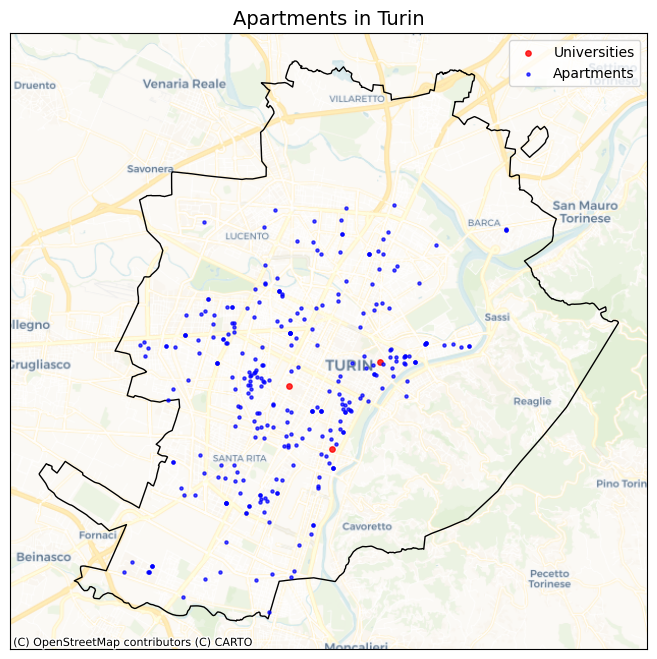

In [ ]:
gdf = gpd.read_file("apartments_final.geojson")

gdf = gdf.to_crs(epsg=3857) 
turin = turin.to_crs(epsg=3857)
centroids = centroids.to_crs(epsg=3857)
gdf = gdf[gdf.geometry.within(turin.unary_union)]

fig, ax = plt.subplots(figsize=(10, 8))

turin.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, label="City Boundary")

centroids.plot(ax=ax, facecolor="red", markersize=15, alpha=0.8, label="Universities")

gdf.plot(ax=ax, facecolor="blue", markersize=5, alpha=0.7, label="Apartments")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, alpha=0.8)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Apartments in Turin", fontsize=14)
plt.legend()
plt.show()

In [ ]:
gdf = gpd.sjoin(
    gdf,
    neighborhoods[["geometry", "Ind. socioeconomico"]],
    how="left",
    predicate="within"
)

gdf = gdf.drop(columns=["index_right"])

C:\Users\re_ma\AppData\Local\Temp\ipykernel_20644\3392520551.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urban_stops["geometry"] = urban_stops.apply(lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1)


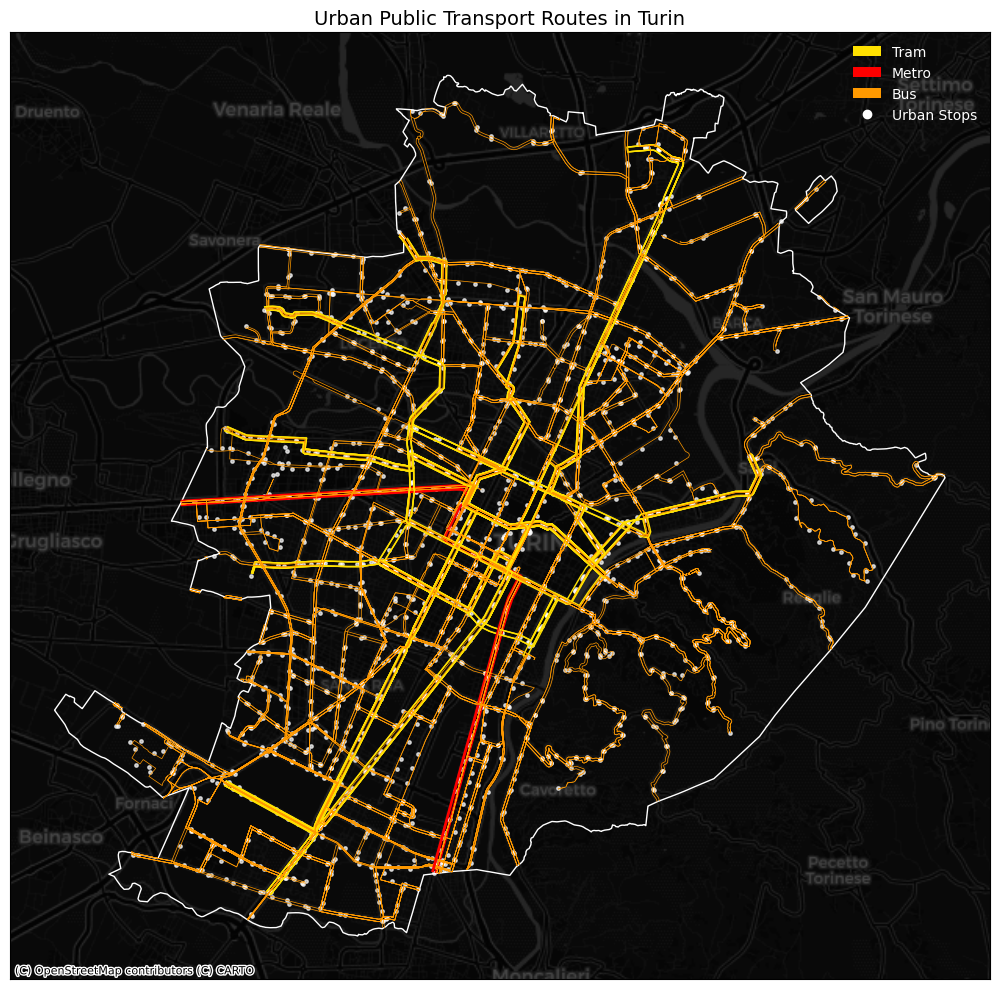

In [ ]:
turin = turin.to_crs(epsg=3857)
routes_df = pd.read_csv("gtfs_data/routes.txt")
trips_df = pd.read_csv("gtfs_data/trips.txt")
shapes_df = pd.read_csv("gtfs_data/shapes.txt")
stop_times_df = pd.read_csv("gtfs_data/stop_times.txt")
stops_df = pd.read_csv("gtfs_data/stops.txt")

# Keep only urban routes
urban_routes = routes_df[routes_df["agency_id"] == "U"]

# Keep trips for urban routes
urban_trips = trips_df[trips_df["route_id"].isin(urban_routes["route_id"])]

# Get shape_ids and corresponding trips
urban_shape_ids = urban_trips["shape_id"].unique()
urban_shapes = shapes_df[shapes_df["shape_id"].isin(urban_shape_ids)]

# Convert shape points into LineStrings
urban_shapes_sorted = urban_shapes.sort_values(by=["shape_id", "shape_pt_sequence"])
route_lines = urban_shapes_sorted.groupby("shape_id").apply(
    lambda df: LineString(zip(df["shape_pt_lon"], df["shape_pt_lat"]))
).reset_index(name="geometry")
gdf_routes = gpd.GeoDataFrame(route_lines, geometry="geometry", crs="EPSG:4326")

# Merge with trip and route info to get route_color
shape_to_trip = urban_trips[["shape_id", "route_id"]].drop_duplicates()
shape_to_color = shape_to_trip.merge(urban_routes[["route_id", "route_color"]], on="route_id", how="left")
gdf_routes = gdf_routes.merge(shape_to_color, on="shape_id", how="left")

gdf_routes["route_color"] = gdf_routes["route_color"].fillna("000000")
gdf_routes["route_color"] = gdf_routes["route_color"].apply(lambda x: f"#{str(x).zfill(6)}")

# Filter stops used in the urban trips
urban_trip_ids = urban_trips["trip_id"]
urban_stop_ids = stop_times_df[stop_times_df["trip_id"].isin(urban_trip_ids)]["stop_id"].unique()
urban_stops = stops_df[stops_df["stop_id"].isin(urban_stop_ids)]
urban_stops["geometry"] = urban_stops.apply(lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1)
gdf_stops = gpd.GeoDataFrame(urban_stops, geometry="geometry", crs="EPSG:4326")

gdf_routes = gdf_routes.to_crs(epsg=3857)
gdf_stops = gdf_stops.to_crs(epsg=3857)

gdf_routes = gpd.clip(gdf_routes, turin)
gdf_stops = gpd.sjoin(gdf_stops, turin, predicate="within", how="inner")

offset_map = {
    "FFE100": 60,  # Metro - yellow
    "FF0000": 45,  # Tram - red
    "FF9900": 30   # Bus - orange
}

fig, ax = plt.subplots(figsize=(12, 10))
turin.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1)

for _, row in gdf_routes.iterrows():
    route_color = row["route_color"].replace("#", "").upper()
    offset_value = offset_map.get(route_color, 0)

    # Set linewidth based on color
    if route_color == "FFE100":
        linewidth = 1
    elif route_color == "FF9900":
        linewidth = 0.5
    else:  
        linewidth = 2

    geom = row.geometry
    offset_geom = None

    try:
        if isinstance(geom, LineString):
            offset_geom = geom.parallel_offset(offset_value, side='left', join_style=2)
        elif isinstance(geom, MultiLineString):
            offset_parts = [
                g.parallel_offset(offset_value, side='left', join_style=2)
                for g in geom.geoms if isinstance(g, LineString)
            ]
            offset_parts = [g for g in offset_parts if not g.is_empty]
            if offset_parts:
                offset_geom = MultiLineString(offset_parts)
    except Exception:
        offset_geom = geom

    if offset_geom and not offset_geom.is_empty:
        gpd.GeoSeries(offset_geom).plot(ax=ax, color=row["route_color"], linewidth=linewidth)
    else:
        gpd.GeoSeries(geom).plot(ax=ax, color=row["route_color"], linewidth=linewidth)

gdf_stops.plot(ax=ax, color="white", markersize=6, alpha=0.7, label="Urban Stops")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, alpha=1, crs=gdf_routes.crs)

legend_lines = [
    Patch(facecolor="#FFE100", edgecolor="none", label="Tram"),
    Patch(facecolor="#FF0000", edgecolor="none", label="Metro"),
    Patch(facecolor="#FF9900", edgecolor="none", label="Bus")
]

legend_point = Line2D(
    [0], [0],
    marker='o',
    color='white',
    label='Urban Stops',
    markersize=6,
    linestyle='None' 
)

legend_elements = legend_lines + [legend_point]

ax.legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=10,
    labelcolor="white"
)

ax.set_title("Urban Public Transport Routes in Turin", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("black")
plt.tight_layout()
plt.show()

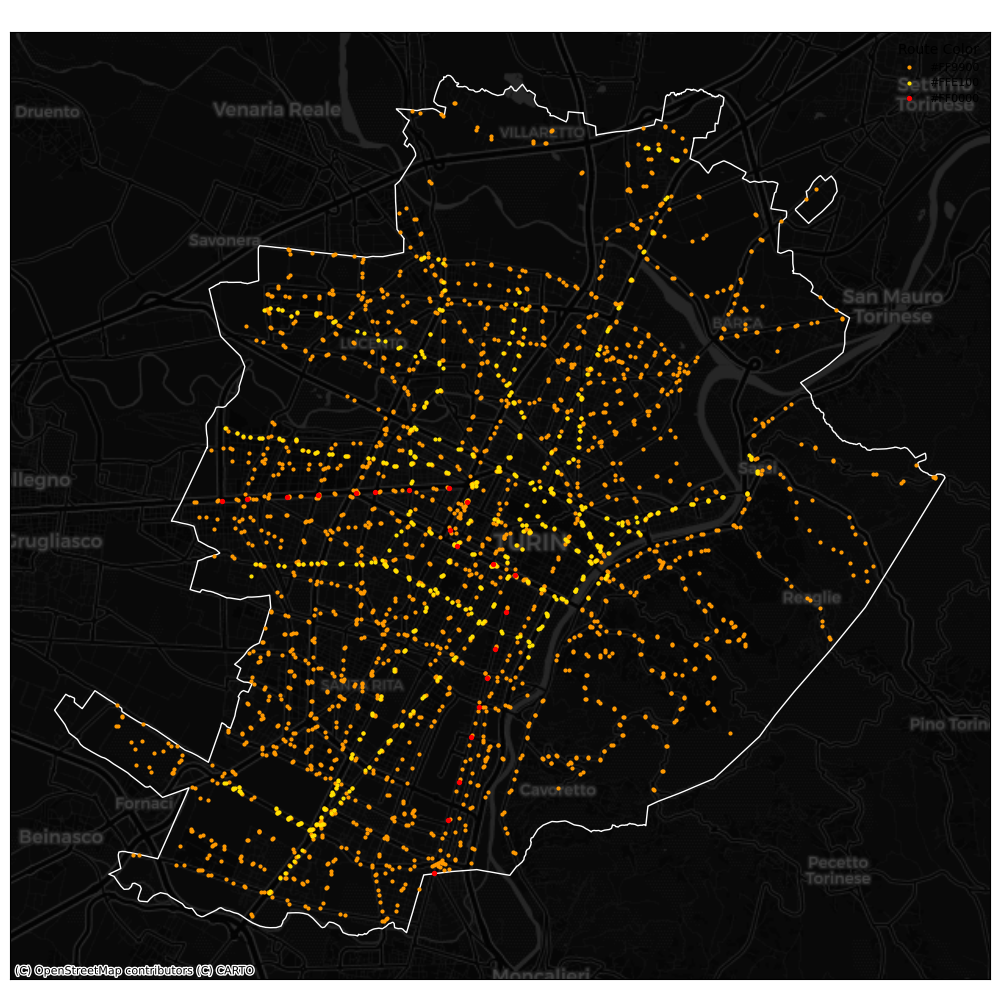

In [ ]:
urban_routes = routes_df[routes_df["agency_id"] == "U"]
urban_trips = trips_df[trips_df["route_id"].isin(urban_routes["route_id"])]
urban_stop_times = stop_times_df[stop_times_df["trip_id"].isin(urban_trips["trip_id"])]
urban_stop_ids = urban_stop_times["stop_id"].unique()
urban_stops = stops_df[stops_df["stop_id"].isin(urban_stop_ids)]

stop_trip_route = urban_stop_times.merge(
    urban_trips[["trip_id", "route_id"]], on="trip_id", how="left"
)
stop_trip_route_color = stop_trip_route.merge(
    urban_routes[["route_id", "route_color"]],
    on="route_id", how="left"
)
stop_trip_route_color = stop_trip_route_color.dropna(subset=["route_color"])
stop_trip_route_color["route_color"] = stop_trip_route_color["route_color"].apply(
    lambda x: f"#{str(x).zfill(6)}"
)

stop_colors = stop_trip_route_color[["stop_id", "route_color"]].drop_duplicates()
colored_stops = urban_stops.merge(stop_colors, on="stop_id", how="inner")
colored_stops["geometry"] = colored_stops.apply(
    lambda row: Point(row["stop_lon"], row["stop_lat"]), axis=1
)
gdf_stops = gpd.GeoDataFrame(colored_stops, geometry="geometry", crs="EPSG:4326").to_crs(epsg=3857)

gdf_stops = gpd.sjoin(gdf_stops, turin, predicate="within", how="inner")

offset_step = 5
unique_colors = gdf_stops["route_color"].unique()
angle_step = 2 * np.pi / len(unique_colors)
color_angles = {color: i * angle_step for i, color in enumerate(unique_colors)}
gdf_stops["geometry_orig"] = gdf_stops.geometry

def offset_geometry(row):
    angle = color_angles[row["route_color"]]
    dx = offset_step * np.cos(angle)
    dy = offset_step * np.sin(angle)
    return Point(row.geometry_orig.x + dx, row.geometry_orig.y + dy)

gdf_stops["geometry"] = gdf_stops.apply(offset_geometry, axis=1)

fig, ax = plt.subplots(figsize=(12, 10))
turin.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1)

for color, group in gdf_stops[gdf_stops["route_color"] != "#FF0000"].groupby("route_color"):
    group.plot(ax=ax, color=color, markersize=4, label=color, zorder=2)

if "#FF0000" in gdf_stops["route_color"].values:
    gdf_stops[gdf_stops["route_color"] == "#FF0000"].plot(
        ax=ax, color="#FF0000", markersize=8, label="#FF0000", zorder=3
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, crs=gdf_stops.crs)

ax.set_title("Urban Stops in Turin by Route Color (Metro on top)", fontsize=14, color="white")
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("black")
ax.legend(title="Route Color", loc="upper right", frameon=False, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
gdf["id"] = gdf.index
centroids["id"] = centroids.index
departure_time = datetime.datetime.strptime("T09:00:00", "T%H:%M:%S")

network = TransportNetwork(
    osm_pbf="Turin.osm.pbf",
    gtfs="gtfs_data.zip"
)

ttm = TravelTimeMatrix(
    transport_network=network,
    origins=gdf.to_crs(epsg=4326),
    destinations=centroids.to_crs(epsg=4326),
    departure=departure_time,
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK]
)

travel_times = ttm

gdf["apartment_index"] = gdf.index
travel_times = travel_times.rename(columns={"from_id": "apartment_index", "to_id": "centroid_id"})

pivoted = travel_times.pivot(index="apartment_index", columns="centroid_id", values="travel_time")
pivoted.columns = [f"travel_time_to_centroid_{i}" for i in pivoted.columns]

gdf_result = gdf.join(pivoted, on="apartment_index")
gdf_result = gdf_result.drop(columns=["Location", "apartment_index"])

gdf_result.to_file("apartment_reachability.geojson", driver="GeoJSON")

c:\Users\re_ma\AppData\Local\Programs\Python\Python310\lib\site-packages\r5py\r5\regional_task.py:196: RuntimeWarning: The currently loaded GTFS data sets do not define any services on 1900-01-01.
  warnings.warn(


In [ ]:
gdf_result = gdf_result.to_crs(epsg=3857)

travel_cols = [
    "travel_time_to_centroid_0",
    "travel_time_to_centroid_1",
    "travel_time_to_centroid_2"
]

incomplete = gdf_result[gdf_result[travel_cols].isnull().any(axis=1)].copy()
complete = gdf_result[gdf_result[travel_cols].notnull().all(axis=1)].copy()

complete_coords = np.array(list(complete.geometry.apply(lambda g: (g.x, g.y))))
incomplete_coords = np.array(list(incomplete.geometry.apply(lambda g: (g.x, g.y))))

nn_model = NearestNeighbors(n_neighbors=1).fit(complete_coords)
distances, indices = nn_model.kneighbors(incomplete_coords)

complete = complete.reset_index(drop=True)
incomplete = incomplete.reset_index()

for i, row in incomplete.iterrows():
    original_idx = row["index"]
    donor_idx = indices[i][0]
    donor_values = complete.loc[donor_idx, travel_cols]
    for col in travel_cols:
        gdf_result.loc[original_idx, col] = donor_values[col]

gdf_result.to_file("apartment_reachability.geojson", driver="GeoJSON")

In [ ]:
gdf = gdf_result.to_crs(epsg=3857).reset_index(drop=True)
coords = np.array([[geom.x, geom.y] for geom in gdf.geometry])
y = gdf['Price (Euro)'].values

k_values = list(range(14, 18)) 

def W_to_binary_matrix(w, n):
    matrix = np.zeros((n, n), dtype=int)
    for i, neighbors in w.neighbors.items():
        matrix[i, neighbors] = 1
    return matrix

results = []

for k in k_values:
    w = KNN.from_array(coords, k=k)
    w.transform = 'b' 

    m = Moran(y, w)
    isolated_count = sum(len(neighs) == 0 for neighs in w.neighbors.values())

    results.append({
        "k (neighbors)": k,
        "Moran's I": m.I,
        "p-value": m.p_sim,
        "Isolated points": isolated_count
    })

results_df = pd.DataFrame(results)
print(results_df)

   k (neighbors)  Moran's I  p-value  Isolated points
0             14   0.013662    0.187                0
1             15   0.009587    0.222                0
2             16   0.007793    0.248                0
3             17   0.009832    0.193                0


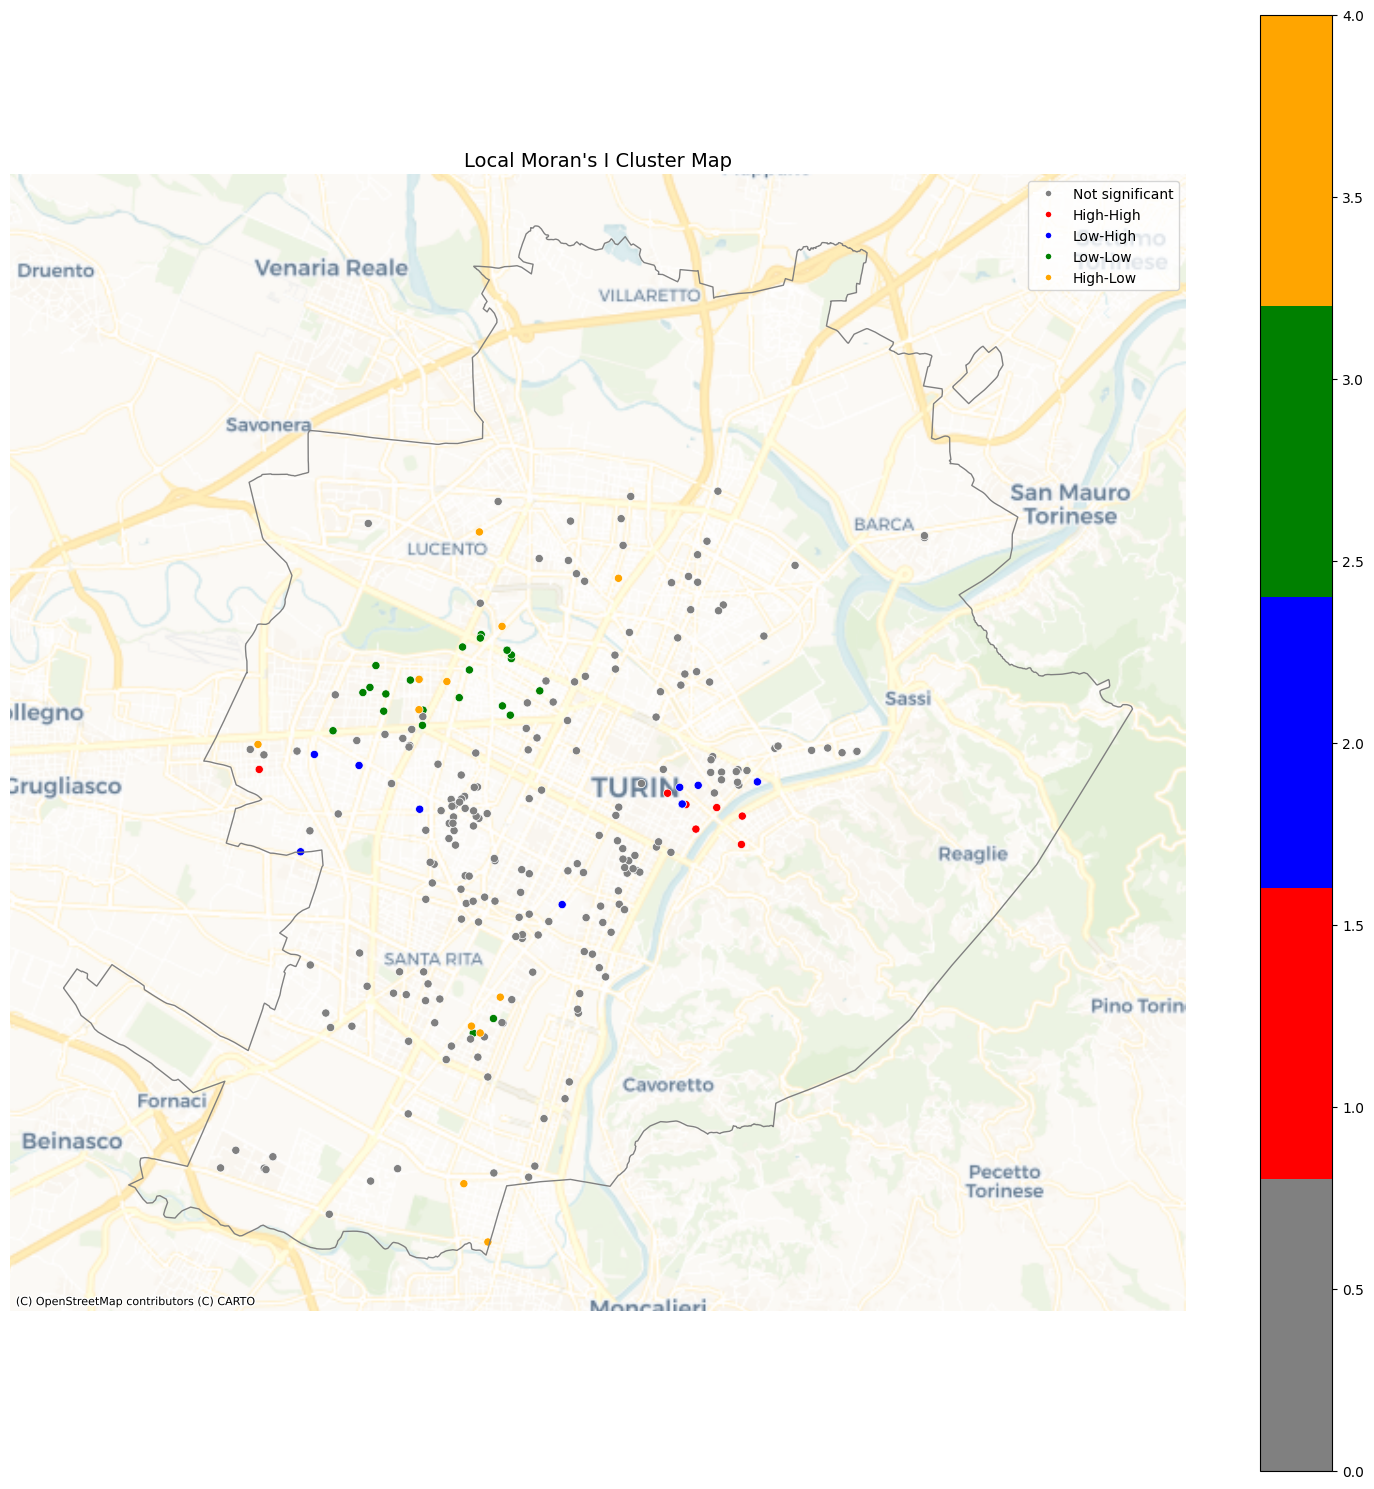

In [ ]:
gdf = gdf.to_crs(epsg=3857)

coords = np.array([[geom.x, geom.y] for geom in gdf.geometry])

k = 20
w = KNN.from_array(coords, k=k)
w.transform = 'r' 

y = gdf['Price (Euro)'].values

lisa = Moran_Local(y, w)

sig = lisa.p_sim < 0.05 
quad = lisa.q

labels = np.zeros_like(quad)
labels[(quad == 1) & sig] = 1  # High-High
labels[(quad == 2) & sig] = 2  # Low-High
labels[(quad == 3) & sig] = 3  # Low-Low
labels[(quad == 4) & sig] = 4  # High-Low

gdf['LISA_Cluster'] = labels

cluster_colors = {
    0: "grey",  # Not significant
    1: "red",         # High-High
    2: "blue",        # Low-High (outlier)
    3: "green",       # Low-Low
    4: "orange"       # High-Low (outlier)
}
cmap = colors.ListedColormap([cluster_colors[i] for i in range(5)])

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='LISA_Cluster', cmap=cmap, linewidth=0.5, edgecolor='white', ax=ax, legend=True, markersize=35)
turin.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=1, label="City Boundary")

legend_labels = {
    0: "Not significant",
    1: "High-High",
    2: "Low-High",
    3: "Low-Low",
    4: "High-Low"
}
handles = [plt.Line2D([0], [0], marker='o', color='w',
            label=legend_labels[i],
            markerfacecolor=cluster_colors[i], markersize=5) for i in range(5)]

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, alpha=0.8)
ax.legend(handles=handles, loc='upper right')
ax.set_title("Local Moran's I Cluster Map", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
gdf = gdf_result.to_crs(epsg=3857) 
predictor_cols = [
    'Area (m²)', 'Rooms', 'Bathrooms',
    'Ind. socioeconomico',
    'travel_time_to_centroid_0',
    'travel_time_to_centroid_1',
    'travel_time_to_centroid_2'
]

gdf[predictor_cols + ['Price (Euro)']] = gdf[predictor_cols + ['Price (Euro)']].apply(pd.to_numeric, errors='coerce')

gdf_clean = gdf.dropna(subset=predictor_cols + ['Price (Euro)']).copy()

y = gdf_clean[['Price (Euro)']].values
X = gdf_clean[predictor_cols].values

X = np.hstack([np.ones((X.shape[0], 1)), X])
name_x = ['CONSTANT'] + predictor_cols

ols_model = OLS(y, X, name_y='Price (Euro)', name_x=name_x)

print(ols_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Price (Euro)                Number of Observations:         297
Mean dependent var  :    435.1077                Number of Variables   :           8
S.D. dependent var  :    131.0046                Degrees of Freedom    :         289
R-squared           :      0.0654
Adjusted R-squared  :      0.0428
Sum squared residual:  4.7478e+06                F-statistic           :      2.8888
Sigma-square        :   16428.375                Prob(F-statistic)     :    0.006223
S.E. of regression  :     128.173                Log likelihood        :   -1858.825
Sigma-square ML     :   15985.860                Akaike info criterion :    3733.649
S.E of regression ML:    126.4352                Schwarz criterion     :    3763.199

------------------------------------------------------------

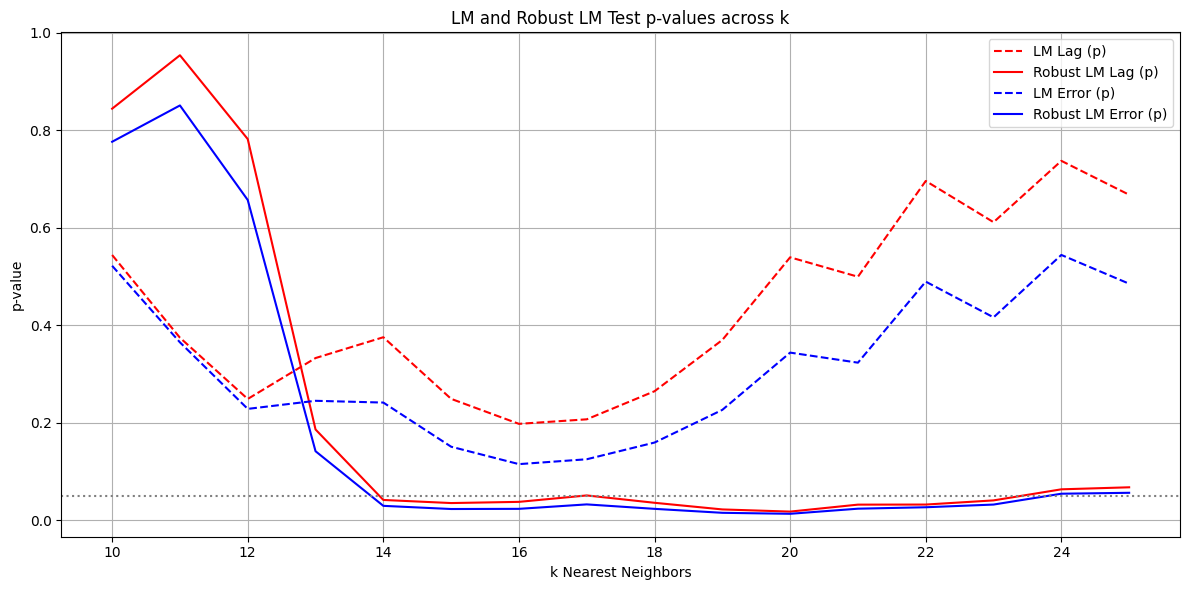

In [ ]:
k_values = range(10, 26)
lm_results = {
    "k": [],
    "LM_lag": [], "p_LM_lag": [],
    "LM_error": [], "p_LM_error": [],
    "Robust_LM_lag": [], "p_Robust_LM_lag": [],
    "Robust_LM_error": [], "p_Robust_LM_error": []
}

for k in k_values:
    w = KNN.from_array(coords, k=k)
    w.transform = 'r'
    lm = LMtests(ols_model, w)
    lm_results["k"].append(k)
    lm_results["LM_lag"].append(lm.lml[0])
    lm_results["p_LM_lag"].append(lm.lml[1])
    lm_results["LM_error"].append(lm.lme[0])
    lm_results["p_LM_error"].append(lm.lme[1])
    lm_results["Robust_LM_lag"].append(lm.rlml[0])
    lm_results["p_Robust_LM_lag"].append(lm.rlml[1])
    lm_results["Robust_LM_error"].append(lm.rlme[0])
    lm_results["p_Robust_LM_error"].append(lm.rlme[1])

df_lm = pd.DataFrame(lm_results)

plt.figure(figsize=(12, 6))
plt.plot(df_lm["k"], df_lm["p_LM_lag"], '--', label="LM Lag (p)", color="red")
plt.plot(df_lm["k"], df_lm["p_Robust_LM_lag"], label="Robust LM Lag (p)", color="red")
plt.plot(df_lm["k"], df_lm["p_LM_error"], '--', label="LM Error (p)", color="blue")
plt.plot(df_lm["k"], df_lm["p_Robust_LM_error"], label="Robust LM Error (p)", color="blue")
plt.axhline(y=0.05, color="gray", linestyle="dotted")
plt.xlabel("k Nearest Neighbors")
plt.ylabel("p-value")
plt.title("LM and Robust LM Test p-values across k")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
gdf = gdf_result.to_crs(epsg=3857)

coords = np.array([[geom.x, geom.y] for geom in gdf.geometry])

k = 15
knn = NearestNeighbors(n_neighbors=k + 1).fit(coords)
_, indices = knn.kneighbors(coords)

neighbors = {}
weights = {}
for i, neighs in enumerate(indices):
    neigh_list = [int(j) for j in neighs if j != i]  
    neighbors[i] = neigh_list
    weights[i] = [1.0] * len(neigh_list)

w = W(neighbors, weights, ids=list(range(len(gdf))))

w.transform = 'r'

predictor_cols = [
    'Area (m²)',
    'Rooms',
    'Bathrooms',
    'Ind. socioeconomico',
    'travel_time_to_centroid_0',
    'travel_time_to_centroid_1',
    'travel_time_to_centroid_2'
]

X = gdf[predictor_cols].astype(float).values
X = np.hstack([np.ones((X.shape[0], 1)), X]) 
y = gdf['Price (Euro)'].astype(float).values.reshape(-1, 1)

lag_model = ML_Lag(
    y, X, w=w,
    slx_lags=1,
    slx_vars="All",
    method="full",
    spat_impacts="simple",
    name_y='Price',
    name_x=['const'] + predictor_cols
)

print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG WITH SLX - SPATIAL DURBIN MODEL (METHOD = FULL)
-------------------------------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :       Price                Number of Observations:         297
Mean dependent var  :    435.1077                Number of Variables   :          16
S.D. dependent var  :    131.0046                Degrees of Freedom    :         281
Pseudo R-squared    :      0.1574
Spatial Pseudo R-squared:  0.1063
Log likelihood      :  -1846.1682
Sigma-square ML     :  14434.4635                Akaike info criterion :    3724.336
S.E of regression   :    120.1435                Schwarz criterion     :    3783.436

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability

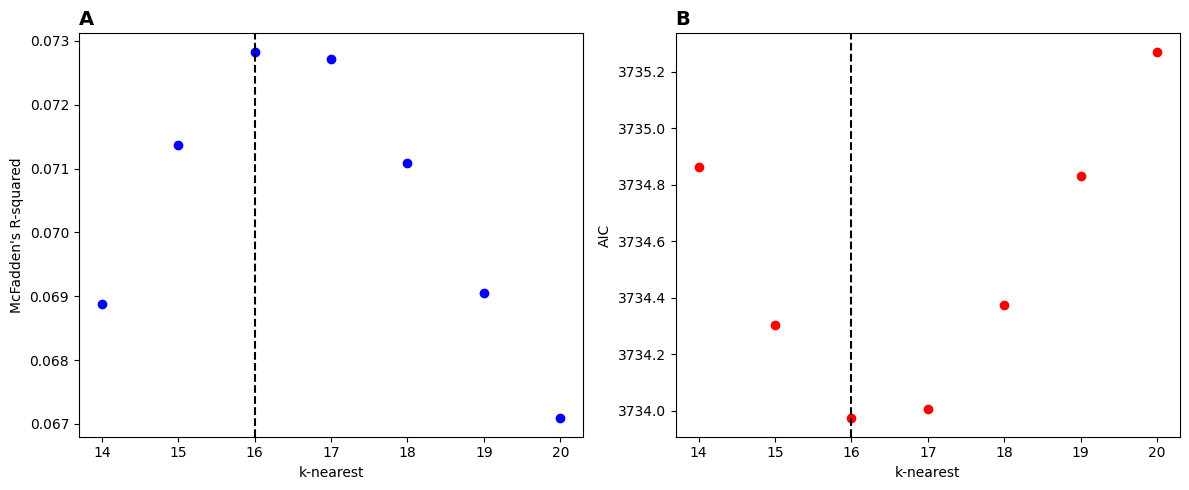

In [ ]:
gdf = gdf_result.to_crs(epsg=3857)

coords = np.array([[geom.x, geom.y] for geom in gdf.geometry])

predictor_cols = [
    'Area (m²)', 'Rooms', 'Bathrooms', 'Ind. socioeconomico',
    'travel_time_to_centroid_0', 'travel_time_to_centroid_1', 'travel_time_to_centroid_2'
]
X_raw = gdf[predictor_cols].astype(float).values
y = gdf['Price (Euro)'].astype(float).values.reshape(-1, 1)
X = np.hstack([np.ones((X_raw.shape[0], 1)), X_raw])
predictor_names = ['const'] + predictor_cols

results = []
k_values = range(14, 21)

for k in k_values:
    w = KNN.from_array(coords, k=k)
    w.transform = 'r'
    model = ML_Lag(
    y, X, w=w,
    slx_lags=1,
    slx_vars="All",
    method="full",
    spat_impacts="simple",
    name_y='Price',
    name_x=predictor_names
)
    results.append({'k': k, 'AIC': model.aic, 'McFadden_R2': model.pr2})

df = pd.DataFrame(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

ax1.scatter(df['k'], df['McFadden_R2'], color='blue')
ax1.axvline(x=df.loc[df['McFadden_R2'].idxmax(), 'k'], linestyle='--', color='black')
ax1.set_xlabel('k-nearest')
ax1.set_ylabel("McFadden's R-squared")
ax1.set_title('A', loc='left', fontsize=14, fontweight='bold')

ax2.scatter(df['k'], df['AIC'], color='red')
ax2.axvline(x=df.loc[df['AIC'].idxmin(), 'k'], linestyle='--', color='black')
ax2.set_xlabel('k-nearest')
ax2.set_ylabel("AIC")
ax2.set_title('B', loc='left', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
print(model.summary)